In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path

# Add project root to sys.path (not src)
project_root = Path.cwd().parent  # Should be RECSYS_FINAL
sys.path.append(str(project_root))

# Import specific modules/functions we want to test
from src import config
from src.data import load_raw
from src.data import utils
from src.data import preprocess  # Import the main preprocessing module

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
print("Setup complete. Modules imported.")

Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Setup complete. Modules imported.


In [2]:
# Test loading all raw data
try:
    raw_data = load_raw.load_all_raw_data()
    print("\nRaw data loaded successfully into 'raw_data' dictionary.")
    # Display shapes
    for name, df in raw_data.items():
        print(f"- {name}: {df.shape}")
except Exception as e:
    print(f"Error loading raw data: {e}")


--- Loading All Raw Data ---
All raw data files found.
Loading assessments data from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/data/raw/assessments.csv
Loaded assessments data shape: (206, 6)
Loading courses data from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/data/raw/courses.csv
Loaded courses data shape: (22, 3)
Loading student assessment data from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/data/raw/studentAssessment.csv
Loaded student assessment data shape: (173912, 5)
Loading student info data from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/data/raw/studentInfo.csv
Loaded student info data shape: (32593, 12)
Loading student registration data from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/data/raw/studentRegistration.csv
Loaded student registration data shape: (32593, 5)
Loading student VLE interaction data from: /Users/mohit/Desktop/ev

In [3]:
# Test cleaning functions (one by one)
print("--- Testing Cleaning Functions ---")
student_info_clean = preprocess.clean_student_info(raw_data['student_info'])
registrations_clean = preprocess.clean_registrations(raw_data['student_registration'])
assessments_clean = preprocess.clean_assessments(raw_data['assessments'])
student_assessment_clean = preprocess.clean_student_assessment(raw_data['student_assessment'])
vle_clean = preprocess.clean_vle(raw_data['vle'])
student_vle_clean = preprocess.clean_student_vle(raw_data['student_vle'])
print("--- Finished Testing Cleaning Functions ---")
# Optional: Print heads/info if needed for debugging
# print("\nCleaned studentInfo Head:\n", student_info_clean.head())
# print("\nCleaned registrations Head:\n", registrations_clean.head())
# print("\nCleaned assessments Head:\n", assessments_clean.head())
# print("\nCleaned studentAssessment Head:\n", student_assessment_clean.head())
# print("\nCleaned vle Head:\n", vle_clean.head())
# print("\nCleaned studentVle Head:\n", student_vle_clean.head())

--- Testing Cleaning Functions ---
Cleaning studentInfo data...
Filled 0 missing imd_band values with 'Missing'.
Creating 'presentation_id' column.
Cleaned studentInfo shape: (32593, 13)
Cleaning studentRegistration data...
Dropped 45 rows with missing date_registration.
Created 'is_unregistered' flag and filled NaNs in 'date_unregistration'.
Creating 'presentation_id' column.
Cleaned studentRegistration shape: (32548, 7)
Cleaning assessments data...
Dropped 11 assessments with missing date (deadline).
Creating 'presentation_id' column.
Cleaned assessments shape: (195, 7)
Cleaning studentAssessment data...
Dropped 173 student assessment records with missing score.
Cleaned studentAssessment shape: (173739, 5)
Cleaning VLE data...
Filled missing 'week_from'/'week_to' with -1.
Creating 'presentation_id' column.
Cleaned VLE shape: (6364, 7)
Cleaning studentVle data...
Creating 'presentation_id' column.
Cleaned studentVle shape: (10655280, 7)
--- Finished Testing Cleaning Functions ---


In [4]:
# Test filtering interactions by registration dates
print("\n--- Testing Registration Filtering ---")
interactions_filtered = preprocess.filter_interactions_by_registration(
    student_vle_clean, registrations_clean
)
print("\nFiltered Interactions Head:\n", interactions_filtered.head())
print(f"\nShape after filtering by registration: {interactions_filtered.shape}")
print("--- Finished Testing Registration Filtering ---")


--- Testing Registration Filtering ---
Filtering VLE interactions based on registration dates...
Merged interactions with registration info. Shape: (10654677, 10)
Filtered out 35231 interactions falling outside registration periods.
Filtered interactions shape: (10619446, 10)

Filtered Interactions Head:
   code_module code_presentation  id_student  id_site  date  sum_click  \
0         AAA             2013J       28400   546652   -10          4   
1         AAA             2013J       28400   546652   -10          1   
2         AAA             2013J       28400   546652   -10          1   
3         AAA             2013J       28400   546614   -10         11   
4         AAA             2013J       28400   546714   -10          1   

  presentation_id  
0       AAA_2013J  
1       AAA_2013J  
2       AAA_2013J  
3       AAA_2013J  
4       AAA_2013J  

Shape after filtering by registration: (10619446, 7)
--- Finished Testing Registration Filtering ---


In [5]:
# Test applying interaction count filters (BEFORE aggregation)
print("\n--- Testing Interaction Count Filtering ---")
# Use the default thresholds from config.py
interactions_count_filtered = preprocess.apply_interaction_count_filters(
    interactions_filtered # Apply to the output of the previous step
)
print("\nInteractions after Interaction Count Filters Head:\n", interactions_count_filtered.head())
print(f"\nShape after interaction count filters: {interactions_count_filtered.shape}")
print(f"\nUnique users remaining: {interactions_count_filtered['id_student'].nunique()}")
print(f"Unique items remaining: {interactions_count_filtered['presentation_id'].nunique()}")
print("--- Finished Testing Interaction Count Filtering ---")


--- Testing Interaction Count Filtering ---
Applying interaction count filters (min_records_per_user=5, min_users_per_item=5)...
 Filter by user interaction count: 10619446 -> 10618254 rows
 Filter by item user count: 10618254 -> 10618254 rows
 Filter by user interaction count: 10618254 -> 10618254 rows
 Filter by item user count: 10618254 -> 10618254 rows
Finished interaction count filtering. Removed 1192 interaction records.
Final filtered interactions shape before aggregation: (10618254, 7)

Interactions after Interaction Count Filters Head:
   code_module code_presentation  id_student  id_site  date  sum_click  \
0         AAA             2013J       28400   546652   -10          4   
1         AAA             2013J       28400   546652   -10          1   
2         AAA             2013J       28400   546652   -10          1   
3         AAA             2013J       28400   546614   -10         11   
4         AAA             2013J       28400   546714   -10          1   

  presen


--- Testing Interaction Aggregation ---
Creating aggregated interaction features (implicit feedback)...
Created aggregated interaction features. Shape: (28466, 7)
   id_student presentation_id  total_clicks  interaction_days  \
0        6516       AAA_2014J          2791               159   
1        8462       DDD_2013J           646                56   
2        8462       DDD_2014J            10                 1   
3       11391       AAA_2013J           934                40   
4       23629       BBB_2013B           161                16   

   first_interaction_date  last_interaction_date  implicit_feedback  
0                     -23                    269           7.934513  
1                      -6                    118           6.472346  
2                      10                     10           2.397895  
3                      -5                    253           6.840547  
4                      -6                     87           5.087596  

Aggregated Interactions 

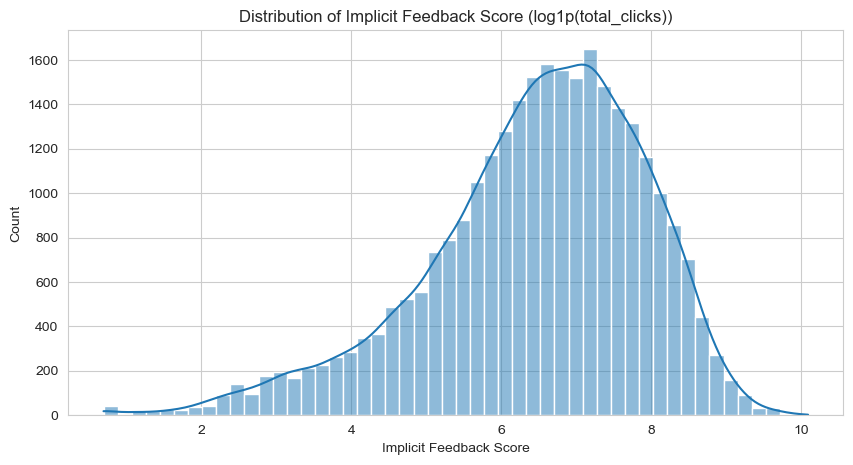

--- Finished Testing Interaction Aggregation ---


In [6]:
# Test creating aggregated interaction features (AFTER count filtering)
print("\n--- Testing Interaction Aggregation ---")
aggregated_interactions = preprocess.create_interaction_features(
    interactions_count_filtered # Apply to the output of the previous step
)
print("\nAggregated Interactions Head:\n", aggregated_interactions.head())
print(f"\nShape of aggregated interactions: {aggregated_interactions.shape}")

# Plot distribution of implicit feedback score if aggregation is not empty
if not aggregated_interactions.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(aggregated_interactions['implicit_feedback'], bins=50, kde=True)
    plt.title('Distribution of Implicit Feedback Score (log1p(total_clicks))')
    plt.xlabel('Implicit Feedback Score')
    plt.ylabel('Count')
    plt.show()
else:
    print("\nAggregated interactions DataFrame is empty, skipping plot.")
print("--- Finished Testing Interaction Aggregation ---")

In [7]:
print("\n--- Testing User Feature Generation ---")
# Generate user features for the valid users found *after filtering and aggregation*
if not aggregated_interactions.empty:
    valid_user_ids_test = aggregated_interactions['id_student'].unique()
    print(f"Number of valid users for feature generation: {len(valid_user_ids_test)}")
    users_features_test = preprocess.generate_user_features(
        student_info_clean, # Pass the cleaned student info
        valid_user_ids_test # Pass the list of valid IDs
    )
    print("\nUser Features Head:\n", users_features_test.head())
    print(f"\nShape of user features: {users_features_test.shape}")
    # Verify shape matches unique user count
    assert users_features_test.shape[0] == len(valid_user_ids_test)
else:
    print("Skipping user feature generation as aggregated_interactions is empty.")
    users_features_test = pd.DataFrame() # Assign empty dataframe
print("--- Finished Testing User Feature Generation ---")



--- Testing User Feature Generation ---
Number of valid users for feature generation: 25364
Generating user features...
Generated user features table. Shape: (25364, 8)
            num_of_prev_attempts  studied_credits  gender_mapped  \
id_student                                                         
6516                           0               60              0   
8462                           1               60              0   
11391                          0              240              0   
23629                          2               60              1   
23698                          0              120              1   

            highest_education_mapped  imd_band_mapped  age_band_mapped  \
id_student                                                               
6516                               3                9                2   
8462                               3                4                2   
11391                              3               10    

In [8]:
print("\n--- Testing Item Feature Generation ---")
# Generate item features for the valid items found *after filtering and aggregation*
if not aggregated_interactions.empty:
    valid_item_ids_test = aggregated_interactions['presentation_id'].unique()
    print(f"Number of valid items for feature generation: {len(valid_item_ids_test)}")
    # Need courses_df with presentation_id
    courses_with_pres_id = utils.create_presentation_id(raw_data['courses'])
    items_features_test = preprocess.generate_item_features(
        courses_with_pres_id, # Pass cleaned courses
        vle_clean, # Pass cleaned VLE info
        valid_item_ids_test # Pass the list of valid IDs
    )
    print("\nItem Features Head:\n", items_features_test.head())
    print(f"\nShape of item features: {items_features_test.shape}")
    # Verify shape matches unique item count
    assert items_features_test.shape[0] == len(valid_item_ids_test)
else:
    print("Skipping item feature generation as aggregated_interactions is empty.")
    items_features_test = pd.DataFrame() # Assign empty dataframe
print("--- Finished Testing Item Feature Generation ---")


--- Testing Item Feature Generation ---
Number of valid items for feature generation: 22
Creating 'presentation_id' column.
Generating item (presentation) features...
Generated item features table. Shape: (22, 21)
                 module_presentation_length  vle_prop_dataplus  \
presentation_id                                                  
AAA_2013J                               268           0.018957   
AAA_2014J                               269           0.019802   
BBB_2013J                               268           0.000000   
BBB_2014J                               262           0.000000   
BBB_2013B                               240           0.000000   

                 vle_prop_dualpane  vle_prop_externalquiz  vle_prop_folder  \
presentation_id                                                              
AAA_2013J                      0.0                    0.0              0.0   
AAA_2014J                      0.0                    0.0              0.0   
BBB_2013J 

In [9]:
# Cell [9] - Optional: Test Full Pipeline
# print("\n--- Testing full preprocess_all_data() function ---")
# processed_data_test = preprocess.preprocess_all_data()
# print("\n--- Full pipeline test finished ---")
# print(f"Final Users shape: {processed_data_test['users'].shape}")
# print(f"Final Items shape: {processed_data_test['items'].shape}")
# print(f"Final Interactions shape: {processed_data_test['interactions'].shape}")